<a href="https://colab.research.google.com/github/kmcguigan1/MNIST-Convs-Torch/blob/lily-99-percent-model/MNIST_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# import statements
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

In [4]:
# use Cuda: change runtime environment to T4 GPU
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# DEVICE
if not torch.backends.mps.is_available():
    DEVICE = torch.device("cpu")
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    DEVICE = torch.device("mps")
DEVICE

device(type='mps')

In [5]:
# initialize parameters

# mean and standard deviation corresponding to the MNIST dataset
mnist_mean = 0.1307
mnist_std_dev = 0.3081

# train and test batch sizes
train_batch_size = 512
test_batch_size = 1000

# learning rate
lr = 0.002
# number of epochs
epochs = 20

In [6]:
def plot_mnist(data):
    # plot a subset of MNIST examples
    fig, axs = plt.subplots(4, 5, figsize=(5, 6))

    plot_images = []
    plot_labels = []

    for i, ax in enumerate(axs.flatten(), start=1000):
        (image, label) = data[i]

        # save the data
        plot_images.append(image)
        plot_labels.append(label)

        # plot each image
        ax.imshow(image.squeeze(), cmap="gray")
        ax.set_title(f"Label: {label}")
        ax.axis("off")
    plt.show()

MNIST EXAMPLES WITHOUT AUGMENTATION


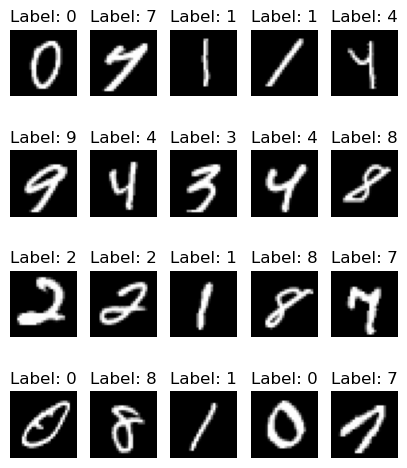

MNIST EXAMPLES WITH AUGMENTATION


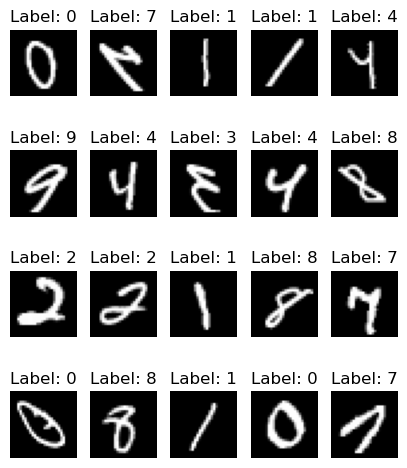

In [7]:
### No augmentation ###
print("MNIST EXAMPLES WITHOUT AUGMENTATION")

# train and test image transforms
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = mnist_mean, std = mnist_std_dev),
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = mnist_mean, std = mnist_std_dev)
])

# train and test data
train_data = torchvision.datasets.MNIST('./files/', train=True, download=True, transform=train_transform)
test_data = torchvision.datasets.MNIST('./files/', train=False, download=True, transform=test_transform)

# train and test data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=test_batch_size)

# plot examples of training data
plot_mnist(train_data)

### Example augmentation ###
print("MNIST EXAMPLES WITH AUGMENTATION")

# train and test image transforms
train_transform_aug = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = mnist_mean, std = mnist_std_dev),
    torchvision.transforms.RandomHorizontalFlip()
])

test_transform_aug = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = mnist_mean, std = mnist_std_dev)
])

# train and test data
train_data_aug = torchvision.datasets.MNIST('./files/', train=True, download=True, transform=train_transform_aug)
test_data_aug = torchvision.datasets.MNIST('./files/', train=False, download=True, transform=test_transform_aug)

# train and test data loaders
train_loader_aug = torch.utils.data.DataLoader(train_data_aug, batch_size=train_batch_size, shuffle=True)
test_loader_aug = torch.utils.data.DataLoader(test_data_aug, batch_size=test_batch_size)

# plot examples of training data
plot_mnist(train_data_aug)

In [11]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, skip_downsample_method='stride_conv'):
        super().__init__()
        # save some info we will need
        self.in_channels, self.out_channels = in_channels, out_channels
        # self.skip_downsample_method = skip_downsample_method
        # self.skip_channel_method = skip_channel_method
        # validate that the use supplied information makes sense
        assert self.out_channels >= self.in_channels
        # first transform block
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, stride=stride)
        self.act1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(out_channels)
        # second transform block
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2)
        self.act2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(out_channels)
        # check if we have an identity block and need to downsample the skip connection
        self.downsample_skip_connection = False
        if(stride > 1):
            self.downsample_skip_connection = True
            if(skip_downsample_method == 'max_pool'):
                self.skip_downsampler = nn.MaxPool2d(kernel_size=stride, stride=stride)
            elif(skip_downsample_method == 'stride_conv'):
                self.skip_downsampler = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, padding=kernel_size//2, stride=stride)

    def _transform_skip_connections(self, inputs):
        # check if we need to downsample the skip connections that we have
        if(self.downsample_skip_connection):
            inputs = self.skip_downsampler(inputs)
        # check if we need to pad with zero channels
        if(self.out_channels > self.in_channels):
            shape = inputs.shape
            padding = torch.zeros(size=(shape[0], self.out_channels - self.in_channels, shape[2], shape[3]))
            inputs = torch.concat((inputs, padding), axis=1)
        return inputs
    
    def forward(self, inputs):
        # conv block one
        x = self.conv1(inputs)
        x = self.act1(x)
        x = self.bn1(x)
        # conv block two
        x = self.conv2(x)
        x = self.act2(x)
        x = self.bn2(x)
        # return the skip connection plus what was learned by this block
        return x + self._transform_skip_connections(inputs)

# im = torch.randn(size=(2, 4, 8, 8))
# im.shape

In [12]:
class FC(nn.Module):
    def __init__(self, in_channels, out_channels, drop_frac=0.4):
        self.linear = nn.Linear(in_channels, out_channels)
        self.act = nn.ReLU()
        self.bn = nn.BatchNorm1d(out_channels)
        self.drop = nn.Dropout(drop_frac)

    def forward(self, x):
        x = self.linear(x)
        x = self.act(x)
        x = self.bn(x)
        return self.drop(x)

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # convolution
        self.conv1 = ConvLayer(1, 8, kernel_size=3, stride=2)
        self.conv2 = ConvLayer(8, 16, kernel_size=3, stride=2)
        self.conv3 = ConvLayer(16, 32, kernel_size=3, stride=1)

        self.output_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        self.output_dropout = nn.Dropout(0.4)

        # classification
        self.dense1 = FC(32, 16)
        self.dense2 = FC(16, 10)
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x = self.output_pool(x)
        x = x.squeeze()

        x = self.dense1(x)
        x = self.dense2(x)

        return self.softmax(x)

In [13]:
def train(model, train_loader, loss_fn, optimizer, epoch=-1):
    # initialize parameters
    total_loss = 0
    all_predictions = []
    all_targets = []
    loss_history = []

    model = model.to(DEVICE) # included so we can use Cuda
    model.train()  # Set model in training mode

    for i, (inputs, targets) in enumerate(train_loader): # 1. fetch next batch of data
        optimizer.zero_grad() # 2. zero the parameter gradients
        inputs = inputs.to(DEVICE) # for use of Cuda
        outputs = model(inputs) # 3. compute model outputs
        loss = loss_fn(outputs, targets.to(DEVICE)) # 4. compute the loss between model outputs and targets (using Cuda)
        loss.backward() # 5. backpropagation
        optimizer.step() # 6. gradient descent


        # Track some values to compute statistics
        total_loss += loss.item()
        # compute the model predictions
        preds = torch.argmax(outputs, dim=-1) # class with the highest output is the prediction

        # track predictions and targets (using Cuda)
        all_predictions.extend(preds.detach().cpu().tolist())
        all_targets.extend(targets.cpu().tolist())

        # Save loss every 100 batches
        if (i % 100 == 0) and (i > 0):
            running_loss = total_loss / (i + 1)
            loss_history.append(running_loss)
            # print(f"Epoch {epoch + 1}, batch {i + 1}: loss = {running_loss:.2f}")

    # compute the accuracy score
    acc = accuracy_score(all_targets, all_predictions)
    final_loss = total_loss / len(train_loader)

    # Print average loss and accuracy
    print(f"Epoch {epoch + 1} done. Average train loss = {final_loss:.2f}, average train accuracy = {acc * 100:.3f}%")
    return acc, final_loss

In [14]:
def test(model, test_loader, loss_fn, epoch=-1):
    # initialize parameters
    total_loss = 0
    all_predictions = []
    all_targets = []

    model = model.to(DEVICE) # included so we can use Cuda
    model.eval()  # Set model in evaluation mode
    for i, (inputs, targets) in enumerate(test_loader): # 1. fetch next batch of data
        with torch.no_grad():
            outputs = model(inputs.to(DEVICE)) # 3. compute model predictions (using Cuda)
            loss = loss_fn(outputs, targets.to(DEVICE)) # 4. compute the loss between model outputs and targets (using Cuda)

            # Track some values to compute statistics
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=-1) # class with the highest output is the prediction

            # track predictions and targets (using Cuda)
            all_predictions.extend(preds.detach().cpu().tolist())
            all_targets.extend(targets.cpu().tolist())

    # compute the accuracy score
    acc = accuracy_score(all_targets, all_predictions)
    final_loss = total_loss / len(test_loader)
    # Print average loss and accuracy
    print(f"Epoch {epoch + 1} done. Average test loss = {final_loss:.2f}, average test accuracy = {acc * 100:.3f}%")
    return acc, final_loss

In [15]:
torch.manual_seed(0)
model = CNN()
#print(model)
optimizer = optim.Adam(model.parameters(), lr)
loss_fn = nn.CrossEntropyLoss()

In [16]:
train_losses = []
test_losses = []
train_metrics = []
test_metrics = []


for epoch in range(epochs):
    train_acc, train_loss = train(model, train_loader, loss_fn, optimizer, epoch)
    test_acc, test_loss = test(model, test_loader, loss_fn, epoch)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_metrics.append(train_acc)
    test_metrics.append(test_acc)

Epoch 1 done. Average train loss = 1.83, average train accuracy = 69.460%
Epoch 1 done. Average test loss = 1.58, average test accuracy = 91.850%
Epoch 2 done. Average train loss = 1.53, average train accuracy = 95.218%
Epoch 2 done. Average test loss = 1.51, average test accuracy = 96.150%
Epoch 3 done. Average train loss = 1.51, average train accuracy = 96.352%
Epoch 3 done. Average test loss = 1.50, average test accuracy = 96.970%
Epoch 4 done. Average train loss = 1.50, average train accuracy = 97.133%
Epoch 4 done. Average test loss = 1.49, average test accuracy = 97.740%
Epoch 5 done. Average train loss = 1.49, average train accuracy = 97.425%
Epoch 5 done. Average test loss = 1.49, average test accuracy = 97.320%
Epoch 6 done. Average train loss = 1.49, average train accuracy = 97.768%
Epoch 6 done. Average test loss = 1.48, average test accuracy = 97.860%
Epoch 7 done. Average train loss = 1.48, average train accuracy = 98.027%
Epoch 7 done. Average test loss = 1.48, average te

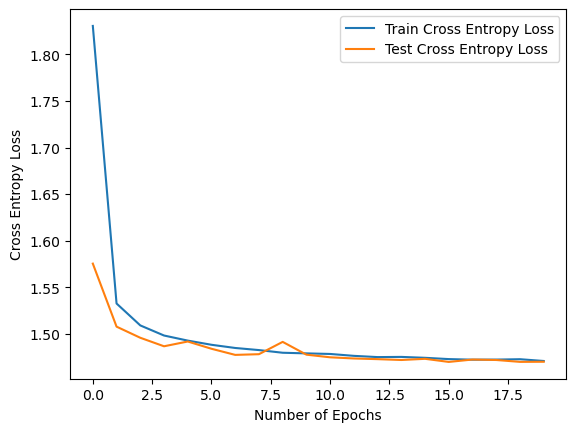

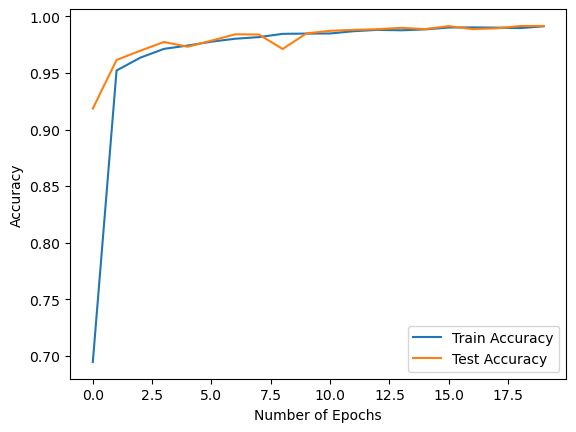

In [17]:
def plot_stats(train, test, title):
    plt.plot(train, label='Train ' + title)
    plt.plot(test, label='Test ' + title)
    plt.xlabel("Number of Epochs")
    plt.ylabel(title)
    plt.legend()
    plt.show()

plot_stats(train_losses, test_losses, "Cross Entropy Loss")
plot_stats(train_metrics, test_metrics, "Accuracy")